Using device: cuda
Loaded 416 graphs
Graph feature matrix shape: torch.Size([416, 7])
Epoch 1/200, Train Loss: 10.4166, Val F1: 0.4322


C:\Users\rakes\anaconda3\envs\gnn_benchmark\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 10/200, Train Loss: 1.2437, Val F1: 0.4322
Epoch 20/200, Train Loss: 0.7557, Val F1: 0.4711
Epoch 30/200, Train Loss: 0.7194, Val F1: 0.1928
Early stopping at epoch 36
Final Test -- Acc: 0.7381, F1: 0.5536, Precision: 0.5919, Recall: 0.5531


C:\Users\rakes\AppData\Local\Temp\ipykernel_27696\2736589078.py:207: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_model.load_state_dict(torch.load(best_model_path))


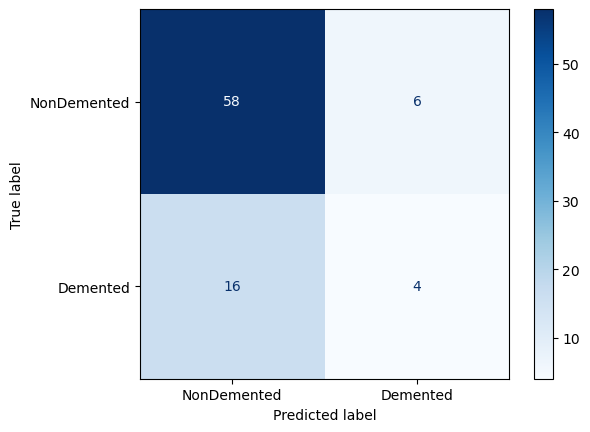

In [2]:
# %% 
# 03_Phase_4_HybridGCN_MLP_Features.ipynb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, BatchNorm, global_mean_pool
from torch_geometric.utils import to_networkx
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('..'))
from config.paths import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %% 
# 1. Load dataset
graph_dataset_path = os.path.join(PROCESSED_DIR, 'oasis_graph_dataset.pt')
graph_list = torch.load(graph_dataset_path, weights_only=False)
print(f"Loaded {len(graph_list)} graphs")

# 2. Extract graph-level features
graph_features = []
labels = []

for g in graph_list:
    labels.append(g.y.item())
    
    # Convert to NetworkX for easy feature calculation
    G_nx = to_networkx(g, to_undirected=True)
    
    # Node-level features
    deg = np.array([d for _, d in G_nx.degree()])
    clustering = np.array(list(nx.clustering(G_nx).values()))
    betweenness = np.array(list(nx.betweenness_centrality(G_nx).values()))
    
    # Aggregate node features per graph (mean)
    deg_mean = deg.mean()
    clustering_mean = clustering.mean()
    betweenness_mean = betweenness.mean()
    
    # Graph-level features
    num_nodes = g.num_nodes
    num_edges = g.num_edges
    avg_degree = deg.mean()
    density = nx.density(G_nx)
    
    # Combine all features into a single vector
    feat = [deg_mean, clustering_mean, betweenness_mean, num_nodes, num_edges, avg_degree, density]
    graph_features.append(feat)

graph_features = torch.FloatTensor(graph_features)
labels = torch.LongTensor(labels)
print(f"Graph feature matrix shape: {graph_features.shape}")

# 3. Add node-level features to GCN (degree)
for g in graph_list:
    row, col = g.edge_index
    degree = torch.bincount(row, minlength=g.num_nodes).float().unsqueeze(1)
    g.x = torch.cat([g.x.unsqueeze(1) if g.x.dim()==1 else g.x, degree], dim=1)

num_node_features = graph_list[0].x.shape[1]

# %% 
# 4. Split dataset
train_idx, test_idx = train_test_split(np.arange(len(graph_list)), test_size=0.2, stratify=labels, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=labels[train_idx], random_state=42)

train_graphs = [graph_list[i] for i in train_idx]
val_graphs = [graph_list[i] for i in val_idx]
test_graphs = [graph_list[i] for i in test_idx]

train_features = graph_features[train_idx]
val_features = graph_features[val_idx]
test_features = graph_features[test_idx]

train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=16)
test_loader = DataLoader(test_graphs, batch_size=16)

# %% 
# 5. Define Hybrid GCN + MLP Model
class HybridGCN_MLP(nn.Module):
    def __init__(self, gcn_in, gcn_hidden, mlp_in, out_channels, dropout=0.5):
        super().__init__()
        # GCN branch
        self.conv1 = GCNConv(gcn_in, gcn_hidden)
        self.bn1 = BatchNorm(gcn_hidden)
        self.conv2 = GCNConv(gcn_hidden, gcn_hidden)
        self.bn2 = BatchNorm(gcn_hidden)
        
        # MLP branch
        self.mlp_fc1 = nn.Linear(mlp_in, mlp_in*2)
        self.mlp_fc2 = nn.Linear(mlp_in*2, mlp_in)
        
        # Final classifier
        self.fc1 = nn.Linear(gcn_hidden + mlp_in, gcn_hidden)
        self.fc2 = nn.Linear(gcn_hidden, out_channels)
        self.dropout = dropout

    def forward(self, data, graph_feats):
        # GCN branch
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = global_mean_pool(x, batch)
        
        # MLP branch
        m = F.relu(self.mlp_fc1(graph_feats))
        m = F.dropout(m, p=self.dropout, training=self.training)
        m = F.relu(self.mlp_fc2(m))
        
        # Concatenate
        h = torch.cat([x, m], dim=1)
        
        # Final classifier
        h = F.relu(self.fc1(h))
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.fc2(h)
        return out

# %% 
# 6. Instantiate model, loss, optimizer
mlp_input_dim = train_features.shape[1]
gcn_model = HybridGCN_MLP(gcn_in=num_node_features, gcn_hidden=64, mlp_in=mlp_input_dim, out_channels=2, dropout=0.5).to(device)

class_counts = [316, 100]
total_samples = sum(class_counts)
class_weights = torch.tensor([total_samples/(2.0*c) for c in class_counts], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(gcn_model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=10, factor=0.5, verbose=True)

# %% 
# 7. Training & evaluation functions
def train_model(model, loader, optimizer, criterion, graph_feats):
    model.train()
    total_loss = 0
    for i, data in enumerate(loader):
        data = data.to(device)
        batch_feats = graph_feats[i*loader.batch_size:(i+1)*loader.batch_size].to(device)
        optimizer.zero_grad()
        out = model(data, batch_feats)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate_model(model, loader, graph_feats):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for i, data in enumerate(loader):
            data = data.to(device)
            batch_feats = graph_feats[i*loader.batch_size:(i+1)*loader.batch_size].to(device)
            out = model(data, batch_feats)
            pred = out.argmax(dim=1)
            ys.append(data.y.cpu())
            preds.append(pred.cpu())
    ys = torch.cat(ys)
    preds = torch.cat(preds)
    acc = accuracy_score(ys, preds)
    f1 = f1_score(ys, preds, average='macro')
    prec = precision_score(ys, preds, average='macro', zero_division=0)
    rec = recall_score(ys, preds, average='macro', zero_division=0)
    cm = confusion_matrix(ys, preds)
    return dict(accuracy=acc, f1=f1, precision=prec, recall=rec, cm=cm)

# %% 
# 8. Train model with early stopping
epochs = 200
best_f1 = 0
best_model_path = './hybrid_gcn_mlp_graphfeat_best.pt'
patience = 20
wait = 0

for epoch in range(1, epochs+1):
    train_loss = train_model(gcn_model, train_loader, optimizer, criterion, train_features)
    val_metrics = evaluate_model(gcn_model, val_loader, val_features)
    
    scheduler.step(val_metrics['f1'])
    
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        torch.save(gcn_model.state_dict(), best_model_path)
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val F1: {val_metrics['f1']:.4f}")

# %% 
# 9. Evaluate on test set
gcn_model.load_state_dict(torch.load(best_model_path))
test_metrics = evaluate_model(gcn_model, test_loader, test_features)

print(f"Final Test -- Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, "
      f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}")

ConfusionMatrixDisplay(confusion_matrix=test_metrics['cm'], display_labels=["NonDemented", "Demented"]).plot(cmap='Blues')
plt.show()
